In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.models import Model
from tensorflow.keras import layers

from PIL import Image
import glob

import os.path
from os import path

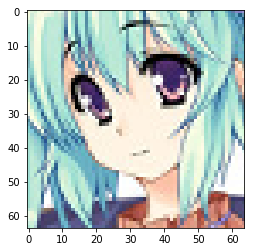

In [2]:
im = Image.open('AnimeFaces/6.png')
plt.imshow(im)
im.close()

#### Let's load images from dataset and convert them to grayscale

In [6]:
images = []
for filename in glob.glob('AnimeFaces\*.png'):
    im = Image.open(filename)
    images.append(np.array(im.convert('L')))
    im.close()

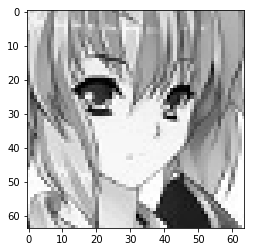

In [7]:
plt.imshow(images[1], cmap='gray', interpolation='none')

#### How many images do we have?

In [8]:
print(len(images))

19124


#### Let's build Neural Network

In [40]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(128, activation='tanh'),
          layers.Dense(128, activation='tanh'),
          layers.BatchNormalization(), 
          layers.Dense(latent_dim, activation='sigmoid')
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(128, activation='tanh'),
          layers.Dense(128, activation='tanh'),
          layers.BatchNormalization(), 
          layers.Dense(4096, activation='sigmoid'),
          layers.Reshape((64,64,1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='MSE')

In [53]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim  
        
        self.encoder = tf.keras.Sequential([
          layers.Conv2D(filters = 5, 
                        kernel_size = (5,5),
                         activation = lambda x: tf.nn.leaky_relu(x, alpha=0.2)),
          layers.BatchNormalization(),
            
          layers.Flatten(),
          layers.Dense(latent_dim, activation='sigmoid')
        ])
        
        self.decoder = tf.keras.Sequential([
          layers.Reshape((8,8,1)),
         layers.Conv2DTranspose(filters = 5, 
                        kernel_size = (5,5),
                        activation = lambda x: tf.nn.leaky_relu(x, alpha=0.2)),
          layers.Flatten(),
          layers.BatchNormalization(), 
          layers.Dense(4096, activation='sigmoid'),
          layers.Reshape((64,64,1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

if(path.isfile('autoencoder.index')):
    autoencoder.load_weights('autoencoder')

In [13]:
e = np.array(images).reshape(-1, 64,64,1)
print(e.shape)

e = e / 255

(19124, 64, 64, 1)


In [42]:
autoencoder.fit(e, e, epochs = 4)

Epoch 1/4
19124/19124 [==============================] - 14s 730us/sample - loss: 0.0393
Epoch 2/4
19124/19124 [==============================] - 14s 726us/sample - loss: 0.0379
Epoch 3/4
19124/19124 [==============================] - 14s 733us/sample - loss: 0.0373
Epoch 4/4
19124/19124 [==============================] - 14s 738us/sample - loss: 0.0368


In [116]:
autoencoder.save_weights('autoencoder')


Consider using a TensorFlow optimizer from `tf.train`.


#### Let's see what out network generates for train dataset

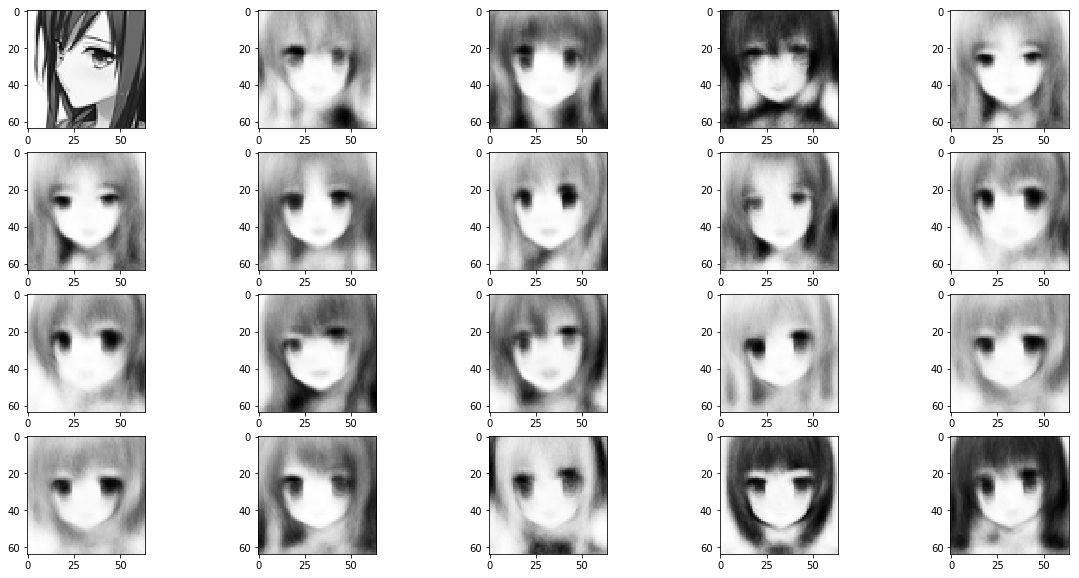

In [54]:
ind = 34
y = autoencoder.predict(e[0:30])

i_size = 4
j_size = 5

fig, axs = plt.subplots(i_size, j_size, figsize=(20, 10))

for i in range(i_size):
    for j in range(j_size):
        axs[i, j].imshow(y[i*i_size + j].reshape(64,64), cmap='gray', interpolation='none')

axs[0,0].imshow(e[ind].reshape(64,64), cmap='gray', interpolation='none')

plt.show()

#### Let's see what our neural network generates randomly

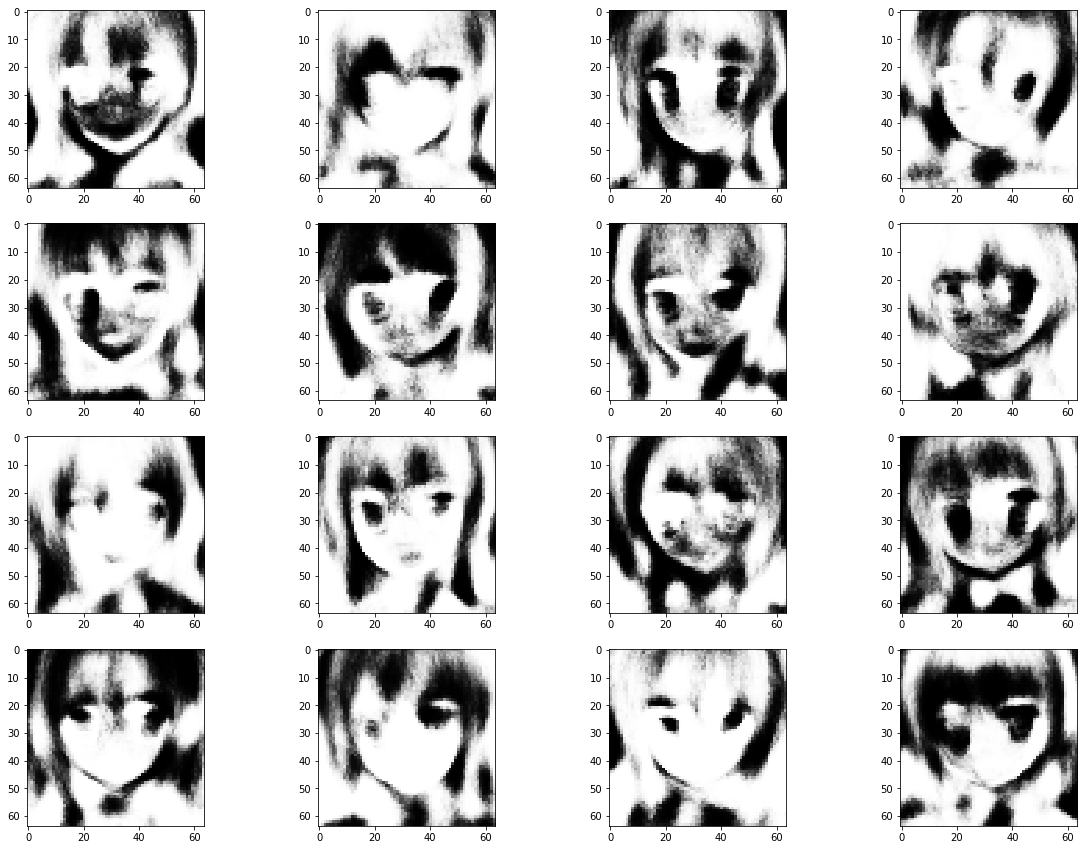

In [55]:
i_size = 4
j_size = 4

fig, axs = plt.subplots(i_size, j_size, figsize=(20, 15))

for i in range(i_size):
    for j in range(j_size):
        rnd = np.random.rand(1,64).astype('float32')
        y = autoencoder.decoder(rnd).numpy()
        axs[i, j].imshow(y.reshape(64,64), cmap='gray', interpolation='none')
plt.show()

#### Well, that looks horrible.
#### New idea. What if we generate random numbers based on normal distribution of our encoded values of our dataset.

In [56]:
encoded_vals = []

for i in range(len(e)):
    encoded_val  = autoencoder.encoder(e[i].reshape(-1,64,64,1).astype('float32')).numpy()
    encoded_vals.append(encoded_val)
    
encoded_vals = np.array(encoded_vals)

In [57]:
print(encoded_vals.shape)

(19124, 1, 64)


In [58]:
#proof that randomly generated should be between 0 and 1, and we just got unlucky 
print(encoded_vals.min())
print(encoded_vals.max())

0.004924923
0.9320247


#### Let's see what's the mean and standart deviation for each feature in our encoded values

In [59]:
mean_std = np.zeros((latent_dim, 2))

for i in range(latent_dim):
    mean_std[i, 0] = encoded_vals[:,0,i].mean()
    mean_std[i, 1] = encoded_vals[:,0,i].std()

    print(f'{i}. Mean {mean_std[i, 0]} Std {mean_std[i, 1]} ')

0. Mean 0.7321405410766602 Std 0.03490476310253143 
1. Mean 0.6874046921730042 Std 0.040086641907691956 
2. Mean 0.4145010709762573 Std 0.06375975161790848 
3. Mean 0.5372039079666138 Std 0.07133866846561432 
4. Mean 0.37440550327301025 Std 0.06395027786493301 
5. Mean 0.24775725603103638 Std 0.03381003811955452 
6. Mean 0.6402854919433594 Std 0.06007954478263855 
7. Mean 0.2241017371416092 Std 0.06988447904586792 
8. Mean 0.6965596079826355 Std 0.10537951439619064 
9. Mean 0.4888286590576172 Std 0.06947691738605499 
10. Mean 0.45376646518707275 Std 0.06996500492095947 
11. Mean 0.50484699010849 Std 0.07610336691141129 
12. Mean 0.4814126789569855 Std 0.07000693678855896 
13. Mean 0.38266822695732117 Std 0.05000779777765274 
14. Mean 0.5215744376182556 Std 0.07041385769844055 
15. Mean 0.3070010840892792 Std 0.04755707085132599 
16. Mean 0.5453232526779175 Std 0.06924096494913101 
17. Mean 0.48988431692123413 Std 0.07087837904691696 
18. Mean 0.5534901022911072 Std 0.0617445707321167 


#### It seems that we indeed should not generate values from uniform distribution. As you can see for the last feature'smean is 0.2423 and standart deviation is 0.04 which means that 95% of all values are between 0.1223 and 0.3623 (3 standart deviations from the mean) and anything beyond that should be considered weird or anomaly.

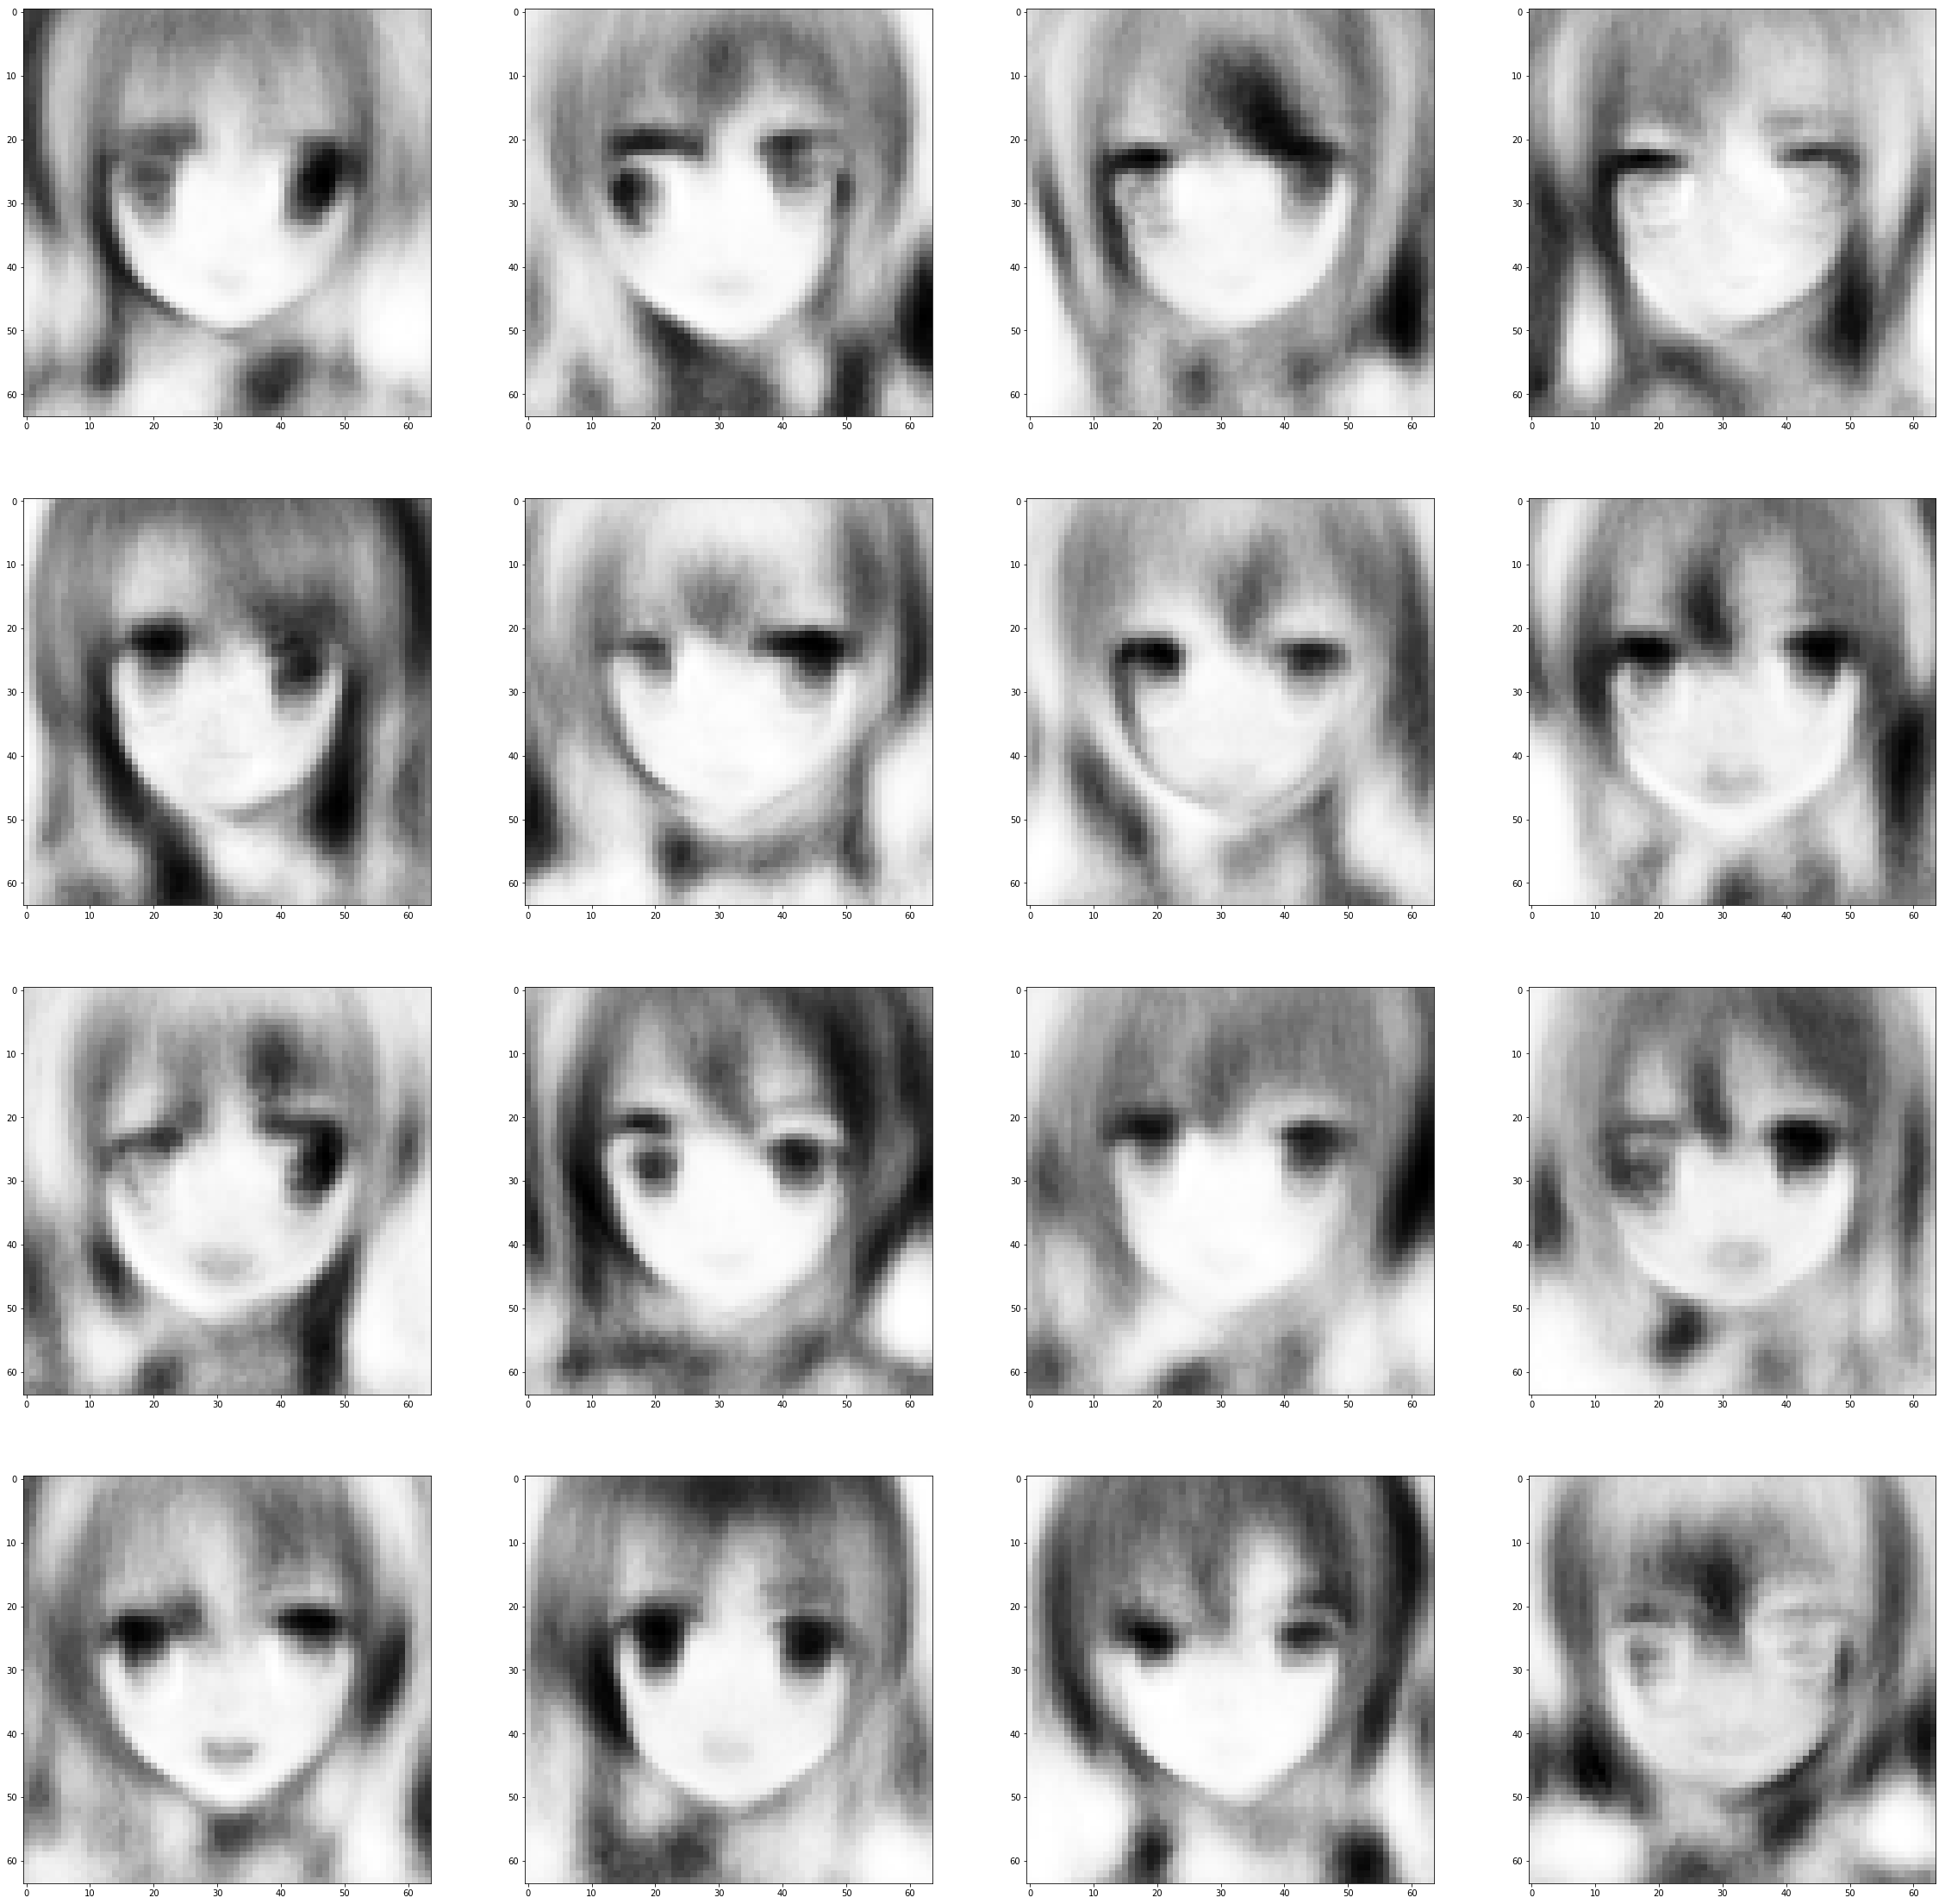

In [60]:
i_size = 4
j_size = 4

fig, axs = plt.subplots(i_size, j_size, figsize=(40, 40))

rnd = np.zeros((1, 64)) 
for i in range(i_size):
    for j in range(j_size):
        for k in range(latent_dim):
            # Generate a random number from normal distribution
            rnd[0, k] = np.random.normal(loc = mean_std[k, 0], 
                                         scale = mean_std[k, 1])
        rnd = rnd.astype('float32')
        y = autoencoder.decoder(rnd).numpy()
        axs[i, j].imshow(y.reshape(64,64), cmap='gray', interpolation='none')
plt.show()

#### That looks much better. 
#### Probably we shoud have used a bit more complicated model and train for a bit longer but I think this is quite a good result.